In [ ]:

%export HF_DATASETS_CACHE="/path/to/another/directory"

## Preprocesado de un conjunto de datos (*dataset*)

El conjunto de datos (*dataset*) que se quiere utilizar para entrenar un modelo debe ser preprocesado al formato de entrada requerido por el mismo. Este formato, tanto si el conjunto de datos lo forman texto, como audio, imágenes, o vídeo, suele tener la forma de grupos (*batches*) de tensores. Para realizar esta transformación, la librería **Transformers** proporciona un conjunto de clases de preprocesado:

- El texto utiliza un *Tokenizer* para convertir el texto en una secuencia de tokens, crear una representación numérica de éstos y ensamblarlos en forma de tensores.
- El audio (también el hablado) utiliza un *Feature extractor* para extraer características secuencias de formas de onda de audio y convertirlas en tensores.
- Las imágenes utilizan un *ImageProcessor* para convertir las imágenes en tensores.
- Las entradas multimodales, usan un *Procesador* para combinar un *tokenizer* y un *feature extractor* o *image processor*

## Procesamiento del lenguaje natural (NLP)

En el caso del lenguaje natural (escrito), la principal herramienta de procesado es, como ya hemos indicado, el *tokenizer*. El *tokenizer* divide el texto en tokens de acuerdo a una serie de reglas determinadas. Dichos tokens son convertirdos en números y después ensamblado en forma de tensores, que a su vez se convierten en entradas del modelo. Cualquier entrada adicional requerida por el modelo es añadida por el *tokenizer*.

Si planeas usar un modelo preentrenado, es importante usar el *tokenizer* preentrenado asociado. Esto asegura que el texto se divida de la misma manera que el corpus de preentrenamiento, y que se usen los mismos *token-to-index* (*vocab*) durante el preentrenamiento.

Comienza por cargar un *tokenizer* preentrenado con la función __AutoTokernizer.from_pretrained()__. Esta función descarga el *vocab* con el que un modelo fue preentrenado.

In [22]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-cased")

Ahora, pasa un pequeño texto al *tokenizer*

In [23]:
encoded_input = tokenizer("Do not meddle in the affairs of wizards, for they are subtle and quick to anger.")
print(encoded_input)

{'input_ids': [101, 2091, 1136, 1143, 13002, 1107, 1103, 5707, 1104, 16678, 1116, 117, 1111, 1152, 1132, 11515, 1105, 3613, 1106, 4470, 119, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


El *tokenizer* devuelve un diccionario con tres items importantes:

- *input_ids*: son lo índices correspondientes a cada token de la frase.
- *attention_mask*: indica si un token debería ser *atendido* o no.
- *token_type_ids*: cuando hay más de una secuencia, identifica a qué secuencia (id) corresponde cada token

Ahora, reconstruye la entrada decodificando los *input_ids*

In [24]:
tokenizer.decode(encoded_input["input_ids"])

'[CLS] Do not meddle in the affairs of wizards, for they are subtle and quick to anger. [SEP]'

Se puede ver que el *tokenizer* añadió dos tokens especiales: CLS y SEP (clasificado y separador) a la frase. No todos los modelos necesitan tokens especiales, pero si los necesitan, el *tokenizer* los añade automáticamente. 

En el caso de tener varias entradas que queremos preprocesar, se las podemos pasar como una lista al *tokenizer*.

In [25]:
batch_sentences = [
    "But what about second breakfast?",
    "Don't think he knows about second breakfast, Pip.",
    "What about elevensies?",
]
encoded_inputs = tokenizer(batch_sentences)
print(encoded_inputs)

{'input_ids': [[101, 1252, 1184, 1164, 1248, 6462, 136, 102], [101, 1790, 112, 189, 1341, 1119, 3520, 1164, 1248, 6462, 117, 21902, 1643, 119, 102], [101, 1327, 1164, 5450, 23434, 136, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1]]}


### Pad

Las frases no tienen siempre la misma longitud, por lo que no generarán tensores del mismo tamaño. Sin embargo, las entradas del modelo necesitan tener una forma uniforme. Para asegurarlo, se utiliza la técnica de *padding* que rellena los tensores más pequeños añadiendo un *padding token* especial a la codificación de las frases más cortas. Esto se hace automáticamente poniendo el parámetro *padding* a *True*.

In [26]:
batch_sentences = [
    "But what about second breakfast?",
    "Don't think he knows about second breakfast, Pip.",
    "What about elevensies?",
]
encoded_input = tokenizer(batch_sentences, padding=True)
print(encoded_input)

{'input_ids': [[101, 1252, 1184, 1164, 1248, 6462, 136, 102, 0, 0, 0, 0, 0, 0, 0], [101, 1790, 112, 189, 1341, 1119, 3520, 1164, 1248, 6462, 117, 21902, 1643, 119, 102], [101, 1327, 1164, 5450, 23434, 136, 102, 0, 0, 0, 0, 0, 0, 0, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]]}


Podemos observar que la primera y la última frase están rellenadas (*padded*) con 0's porque son más cortas.

### Truncation

En el otro extremo, a veces tenemos en la entrada frases tan largas que exceden la dimensionalidad permitida por el modelo. En ese caso, vamos a acortar (*truncate*) la secuencia a una más corta. Para ello, vamos a poner el parámetro *truncation* a *True* para truncar la secuencia a la máxima longitud permitida por el modelo.

In [27]:
batch_sentences = [
    "But what about second breakfast?",
    "Don't think he knows about second breakfast, Pip.",
    "What about elevensies?",
]
encoded_input = tokenizer(batch_sentences, padding=True, truncation=True)
print(encoded_input)

{'input_ids': [[101, 1252, 1184, 1164, 1248, 6462, 136, 102, 0, 0, 0, 0, 0, 0, 0], [101, 1790, 112, 189, 1341, 1119, 3520, 1164, 1248, 6462, 117, 21902, 1643, 119, 102], [101, 1327, 1164, 5450, 23434, 136, 102, 0, 0, 0, 0, 0, 0, 0, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]]}


### Tensors

El último paso es que el *tokenizer* devuelva el texto que se utilizará como entrada del modelo. Para ello fijamos el valor del parámetro *return_tensors* a *pt* para Pytorch o a *tf* para TensorFlow

In [28]:
batch_sentences = [
    "But what about second breakfast?",
    "Don't think he knows about second breakfast, Pip.",
    "What about elevensies?",
]
encoded_input = tokenizer(batch_sentences, padding=True, truncation=True, return_tensors="pt")
print(encoded_input)

{'input_ids': tensor([[  101,  1252,  1184,  1164,  1248,  6462,   136,   102,     0,     0,
             0,     0,     0,     0,     0],
        [  101,  1790,   112,   189,  1341,  1119,  3520,  1164,  1248,  6462,
           117, 21902,  1643,   119,   102],
        [  101,  1327,  1164,  5450, 23434,   136,   102,     0,     0,     0,
             0,     0,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]])}


## Audio

Para tareas de audio, necesitaremos un *FeatureExtractor* para preparar tu *dataset* para el modelo. Éste está diseñado para extraer las características a partir de datos de audio *raw*. y convertirlos a tensores.

En el siguiente ejemplo, cargamos el *dataset* [MInDS-14](https://huggingface.co/datasets/PolyAI/minds14)

In [37]:
from datasets import load_dataset, Audio

dataset = load_dataset("PolyAI/minds14", name="en-US", split="train")

Found cached dataset minds14 (/home/ulc/es/dac/.cache/huggingface/datasets/PolyAI___minds14/en-US/1.0.0/7bdf27fccad4efc6da7c00f739d96bfa0d25a7a85f2244755a73c865f70182bc)


Ahora, accedemos al primer elemento de la columna *audio* del *dataset* para echarle un vistazo a la entrada. La llamada a la columna *audio* carga automátivamente y *resamplea* el fichero de audio.

In [38]:
dataset[0]["audio"]

{'path': '/home/ulc/es/dac/.cache/huggingface/datasets/downloads/extracted/70346322a48214c0221346ba84f4e459875ee8746b137eea0c3c6c4682caaa21/en-US~JOINT_ACCOUNT/602ba55abb1e6d0fbce92065.wav',
 'array': array([ 0.        ,  0.00024414, -0.00024414, ..., -0.00024414,
         0.        ,  0.        ]),
 'sampling_rate': 8000}

Como vemos, ésto devuelve tres elementos:

- *array*: es la señal de audio (conteniendo habla), y potencialmente remuestreado como un array de una dimensión.
- *path*: la ruta donde se encuentre el fichero de audio.
- *sampling_rate*: es el número de puntos de la señal medidos por segundo.

En esta demonstración, vamos a utilizar el modelo [Wav2Vec2](https://huggingface.co/facebook/wav2vec2-base). Mirando las características de este modelo, vemos que ha sido preentrenado con audio (hablado) muestrado a 16 kHz (16000 muestras por segundo). Es importante que la tasa de muestreo de tu audio coincida con la tasa de muestreo usada para entrenar el modelo. Si no es así, deberás volver a muestrear tus datos. En este sentido, podemos:

1. Usar el método *cast_column* del *dataset* para aumentar la tasa de muestreo a 16kHz

In [39]:
dataset = dataset.cast_column("audio", Audio(sampling_rate=16_000))

2. Luego accedemos a la columna audio otra vez para volver a muestrear el fichero de audio

In [40]:
dataset[0]["audio"]

{'path': '/home/ulc/es/dac/.cache/huggingface/datasets/downloads/extracted/70346322a48214c0221346ba84f4e459875ee8746b137eea0c3c6c4682caaa21/en-US~JOINT_ACCOUNT/602ba55abb1e6d0fbce92065.wav',
 'array': array([ 1.70562416e-05,  2.18727451e-04,  2.28099874e-04, ...,
         3.43842403e-05, -5.96364771e-06, -1.76846661e-05]),
 'sampling_rate': 16000}

A continuación, usa un *feature extractor* para normalizar y rellenr la entrada. Recuerda que para secuencias de texto, se añadían 0's a las secuencias más cortas. En el caso de audio, añadimos también 0's los cuales se interpretar como silencio.

Vamos a hacer ahora una pequeña demonstración. Primero, tenemos que cargar el *feature extractor* apropiado para este modelo.

In [41]:
from transformers import AutoFeatureExtractor

feature_extractor = AutoFeatureExtractor.from_pretrained("facebook/wav2vec2-base")

/mnt/netapp2/Store_uni/home/ulc/es/dac/mytx/lib/python3.7/site-packages/transformers/configuration_utils.py:381: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  "Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 "


Una vez cargado, pasamos el *array* de audio al *feature extractor* También podemos especificar el *sampling_rate* como argumento del *feature exteractor*. Esto será muy útil para depurar errores que puedan ocurrir.

In [42]:
audio_input = [dataset[0]["audio"]["array"]]
feature_extractor(audio_input, sampling_rate=16000)

{'input_values': [array([ 3.0293269e-04,  2.7676334e-03,  2.8821775e-03, ...,
        5.1470479e-04,  2.1597825e-05, -1.2164921e-04], dtype=float32)]}

Como en el caso del tokenizador, se puede aplicar *padding* o *truncation* para manejar la existencia de secuencias de tamaño distinto en un *batch*. Por ejemplo, echa un vistazo a la longitud de estas dos secuencias.

In [44]:
dataset[0]["audio"]["array"].shape

dataset[1]["audio"]["array"].shape

(106496,)

Ahora, vamos a crear una función para preprocesar el *dataset* de forma que las muestras de audio tenga las mismas longitudes. Especifica una longitud máxima de muestra, y el *feature extractor* truncará o rellenerá cada secuencia a esa longitud.

In [45]:
def preprocess_function(examples):
    audio_arrays = [x["array"] for x in examples["audio"]]
    inputs = feature_extractor(
        audio_arrays,
        sampling_rate=16000,
        padding=True,
        max_length=100000,
        truncation=True,
    )
    return inputs

Ahora, aplicamos esta función a las primeras muestras del *dataset*

In [46]:
processed_dataset = preprocess_function(dataset[:5])

Como las secuencias tienen ahora la misma longitud, están listas para ser pasadas al modelo.

In [47]:
processed_dataset["input_values"][0].shape

processed_dataset["input_values"][1].shape

(100000,)

## Visión por computador

En el caso de tareas de visión por computador, vamos a necesitar un *image processor* para preparar el *dataset* para el modelo. El procesado de imágenes requiere varios pasos para convertir las imágenes a los tensores de entrada necesarios para el modelo. Estos pasos incluyen, pero no está necesariamente limitados a: cambiar el tamaño, normalización, corrección del canal de color, y convertir las imágenes a tensores.



El preprocesado de imágenes a menudo implica alguna forma de aumentación (*augmentation*) de la imagen. Los procesos de preprocesado y aumentación de la imagen transforman los datos de la imagen pero sirven a propósitos diferentes:

- *Image augmentation*: altera una imagen de forma que previene *overfitting* e incrementa la robustez del modelo. Se utilizan para ellos técnicas creativas como: ajuste de brillo y color, recortado, rotación, reescalado, zoom, etc...
- *Image preprocessing*: este proceso garantiza que la imagen cumple el formato de entrada esperado por el modelo. Cuando se hace *fine-tuning* de un modelo de visión por computador, las imágenes se deben preprocesar del mismo modo al que se hizo cuando el modelo fue entrenado por primera vez.

Vamos a ver ahora un ejemplo usando el *dataset* [food101](https://huggingface.co/datasets/food101).

En este ejemplo vamos a usar el parámetro *split* para extraer solo una pequeña parte del subconjunto de entrenamiento, ya que éste es realmente grande.

In [51]:
from datasets import load_dataset

dataset = load_dataset("food101",path="", split="train[:10]")

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/75750 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /home/ulc/es/dac/.cache/huggingface/datasets/parquet/food101-4a7cae0b26eea62a/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7. Subsequent calls will reuse this data.


Ahora, échale un vistazo a una de las imágenes.

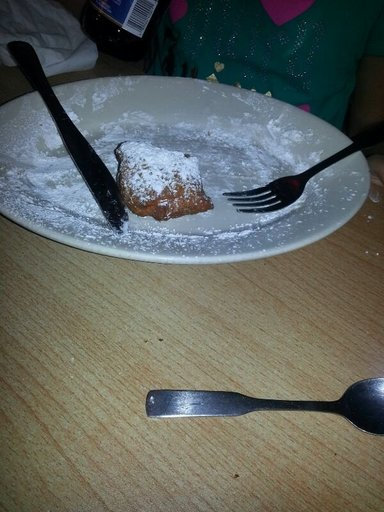

In [52]:
dataset[0]["image"]

Carga el procesador de imagen.

In [53]:
from transformers import AutoImageProcessor

image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")

En primer lugar, vamos a aumentar el *dataset*. Para ello, vamos a utilizar del módulos *transforms*. Sin embargo, [existen otras muchas opciones](https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/image_classification_albumentations.ipynb) para realizar este proceso.

In [55]:
%pip install torchvision

from torchvision.transforms import RandomResizedCrop, ColorJitter, Compose

size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
)

# Compone una secuencia de transformaciones de la imagen
_transforms = Compose([RandomResizedCrop(size), ColorJitter(brightness=0.5, hue=0.5)])

# image_processor normaliza las imágenes y las convierte en tensores
# el modelo acepta los pixel_values como entrada
def transforms(examples):
    images = [_transforms(img.convert("RGB")) for img in examples["image"]]
    # do_resize está a False porque ya se ha hecho el resize
    examples["pixel_values"] = image_processor(images, do_resize=False, return_tensors="pt")["pixel_values"]
    return examples

# Aplica las transformaciones a los datos
dataset.set_transform(transforms)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.2/24.2 MB 161.0 MB/s eta 0:00:001m196.2 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


Vemos que el *image processor* ha añadido el campo pixel_values a los datos.

In [56]:
dataset[0].keys()

dict_keys(['image', 'label', 'pixel_values'])

Veamos cómo se ve la imagen que visualizamos antes una vez hecha la transformación. La imagen ha sido recortada aleatoriamente y se han alterado sus propiedades de color.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


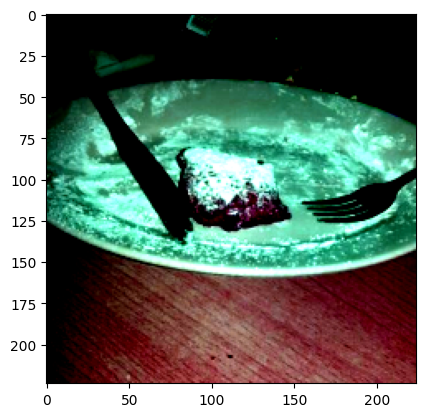

In [57]:
import numpy as np
import matplotlib.pyplot as plt

img = dataset[0]["pixel_values"]
plt.imshow(img.permute(1, 2, 0))

Para tareas como detección de objetos o segmentación *ImageProcessor* ofrece tareas de post-procesado. Estos métodos convierten las salidas *raw* del modelo en ¢|predicciones con significado, tales como *bounding boxes* o *segmentation maps*.

## Multimodal

Para tareas que implican entradas multimodales, vamos a necesitar un *processor* para preparar el *dataset* para el modelo. Dicho *processor* acopla dos objetos de procesado distintos como un *tokenizer* y un *feature extractor*.

Como ejemplo, vamos a cargar el *dataset* [LJ Speech](https://huggingface.co/datasets/lj_speech) y lo usaremos para usar el *processor* en una aplicación de ASR.

In [65]:
import os
os.environ['HF_DATASETS_CACHE'] = os.getenv('STORE')+"/mytx"
from datasets import load_dataset
# Cargar el conjunto de datos de LJ Speech
lj_speech = load_dataset("lj_speech", split="train[:10]")
# Eliminar columnas innecesarias ya que para ASR solo necesitamos el audio y el texto
lj_speech = lj_speech.map(remove_columns=["file", "id", "normalized_text"])
# Observar una muestra de ambas columnas
lj_speech[0]["audio"]
lj_speech[0]["text"]
# Hacemos un nuevo muestro del audio al sample_rate de 16kHz (el usado para entrenar el modelo)
lj_speech = lj_speech.cast_column("audio", Audio(sampling_rate=16_000))
from transformers import AutoProcessor
# Cargamos el processor adecuado
processor = AutoProcessor.from_pretrained("facebook/wav2vec2-base-960h")
# Definimos una función para preparar el conjunto de datos
# Esta función tokeniza el texto (a labels) y extrae las features de los audios (a input_values)
def prepare_dataset(example):
    audio = example["audio"]
    example.update(processor(audio=audio["array"], text=example["text"], sampling_rate=16000))
    return example
# Aplicamos la función al primer sample del conjunto de datos
prepare_dataset(lj_speech[0])

Found cached dataset lj_speech (/home/ulc/es/dac/.cache/huggingface/datasets/lj_speech/main/1.1.0/179f3aa320f870f21c4b9fcd1390748fde6a0dcd70561f2d883b6fdfa6cbee04)
Loading cached processed dataset at /home/ulc/es/dac/.cache/huggingface/datasets/lj_speech/main/1.1.0/179f3aa320f870f21c4b9fcd1390748fde6a0dcd70561f2d883b6fdfa6cbee04/cache-1603348e973dbff2.arrow


FileNotFoundError: [Errno 2] No such file or directory: '/home/ulc/es/dac/.cache/huggingface/datasets/downloads/extracted/cbf924ac2109e5607983d7598aebc138bca670b677a584e5e48ba4f53593925e/LJSpeech-1.1/wavs/LJ001-0001.wav'

El processor ha añadido input_values y labels, y la frecuencia de muestreo también se ha reducido correctamente a 16kHz. Ya podemos pasar tu conjunto de datos procesado al modelo.